In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# we got error in pascal-context dataset for device-side assert triggered error on CUDA
# ✅: Enable immediate error reporting
#This forces CUDA errors to appear exactly where they happen.

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
#cell 3 install dependencies

!pip install timm opencv-python scikit-image matplotlib torchvision yacs

In [ ]:
#---------------load data from nyu_data into nyu2_train-------------------------->



# import zipfile, shutil, os
# from pathlib import Path
# from tqdm import tqdm

# # === CONFIGURATION ===
# zip_path = "/content/drive/MyDrive/DeMT/nyu_data.zip"
# extract_temp_path = "/content/temp_extract"
# target_dataset_path = "/content/drive/MyDrive/DeMT/data/nyu2_train"

# # === PREPARE DIRECTORIES ===
# shutil.rmtree(extract_temp_path, ignore_errors=True)
# os.makedirs(extract_temp_path, exist_ok=True)
# os.makedirs(target_dataset_path, exist_ok=True)

# # === UNZIP ===
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_temp_path)

# # === DEBUG: See What Was Extracted ===
# print("\n📂 Extracted Folder Structure:")
# for root, dirs, files in os.walk(extract_temp_path):
#     print(f"ROOT: {root}")
#     for d in dirs:
#         print(f"  DIR: {d}")
#     for f in files:
#         print(f"  FILE: {f}")

# # === SET DATA ROOT BASED ON ACTUAL STRUCTURE ===
# # Change based on above output
# data_root = Path(extract_temp_path) / "data" / "nyu2_train"

# # === PROCESS FILES ===
# file_count = 0
# all_folders = list(data_root.glob("*"))
# print(f"\nFound {len(all_folders)} folders. Processing...")

# for folder in tqdm(all_folders, desc="Flattening folders"):
#     if folder.is_dir():
#         folder_name = folder.name
#         for file in folder.glob("*"):
#             if file.suffix.lower() not in [".jpg", ".png"]:
#                 continue
#             new_name = f"{folder_name}_{file.stem}{file.suffix.lower()}"
#             dest_path = Path(target_dataset_path) / new_name
#             if not dest_path.exists():
#                 shutil.move(str(file), str(dest_path))
#                 file_count += 1

# print(f"\n✅ {file_count} files moved to flat folder:")
# print(target_dataset_path)

In [ ]:
#cell 3-->prreprocessing
import os
import cv2
import numpy as np
import torch
from PIL import Image
from skimage.filters import sobel
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms

# -----------------------------
# ✅ Normalize RGB image (H, W, 3) in [0, 255] → [0, 1] → normalized
def normalize_rgb(rgb):
    rgb = rgb / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (rgb - mean) / std

# -----------------------------
# ✅ Convert depth map to surface normals
def depth_to_normals(depth):
    dzdx = np.gradient(depth, axis=1)
    dzdy = np.gradient(depth, axis=0)
    normal = np.dstack((-dzdx, -dzdy, np.ones_like(depth)))
    return normal / (np.linalg.norm(normal, axis=2, keepdims=True) + 1e-8)

# -----------------------------
# ✅ Create boundary/edge map from segmentation
def generate_boundary(seg):
    return (sobel(seg) > 0.01).astype(np.uint8)

# -----------------------------
# ✅ Load pretrained DeepLabv3 with proper transforms
weights = DeepLabV3_ResNet101_Weights.DEFAULT
deeplab = deeplabv3_resnet101(weights=weights).eval()
transform = weights.transforms()

# -----------------------------
# ✅ Generate pseudo-segmentation label from RGB
def get_segmentation(rgb):
    """
    Input: normalized RGB image in [0, 1], shape (H, W, 3)
    Output: segmentation map, shape (H, W)
    """
    img_uint8 = (rgb * 255).astype(np.uint8)             # back to uint8
    pil_image = Image.fromarray(img_uint8)               # convert to PIL
    img_tensor = transform(pil_image).unsqueeze(0)       # apply DeepLab transforms

    with torch.no_grad():
        out = deeplab(img_tensor)['out']

    seg = out.argmax(1).squeeze().cpu().numpy().astype(np.uint8)
    return seg


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 140MB/s]


In [ ]:
# # .......................📌 Cell 4: Preprocess NYUD-v2 Dataset (Overwrite if exists, no duplicates) //dont run always.........

# import os
# import cv2
# import numpy as np

# nyu_path = '/content/drive/MyDrive/DeMT/data/nyu2_train'
# nyu_out = '/content/drive/MyDrive/DeMT/data/nyud_preprocessed'

# os.makedirs(nyu_out, exist_ok=True)

# for fname in sorted(os.listdir(nyu_path)):
#     if fname.endswith('.jpg'):
#         file_id = fname.replace('.jpg', '')
#         rgb_path = os.path.join(nyu_path, file_id + '.jpg')
#         depth_path = os.path.join(nyu_path, file_id + '.png')
#         save_path = os.path.join(nyu_out, f"{file_id}.npz")

#         # Load RGB and depth
#         rgb = cv2.imread(rgb_path)[:, :, ::-1]
#         depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

#         # Resize
#         rgb = cv2.resize(rgb, (320, 240))
#         depth = cv2.resize(depth, (320, 240))

#         # Normalize
#         rgb = normalize_rgb(rgb)
#         depth = depth.astype(np.float32)
#         depth /= (depth.max() + 1e-8)

#         # Generate additional data
#         normal = depth_to_normals(depth)
#         seg = get_segmentation((rgb * 255).astype(np.uint8))
#         boundary = generate_boundary(seg)

#         # Save (overwrite if exists)
#         np.savez_compressed(save_path, rgb=rgb, depth=depth, normal=normal,
#                             segmentation=seg, boundary=boundary)
#         print("✅ Overwritten or saved:", save_path)


In [ ]:
# import matplotlib.pyplot as plt
# import cv2
# import numpy as np
# import os

# # 🔄 Choose a sample image ID (based on your file names)
# image_id = 'basement_0001a_out_99'

# # Raw and processed paths
# raw_rgb_path = f"/content/drive/MyDrive/DeMT/data/nyu2_train/{image_id}.jpg"
# preprocessed_path = f"/content/drive/MyDrive/DeMT/data/nyud_preprocessed/{image_id}.npz"

# # Load original image
# raw_rgb = cv2.imread(raw_rgb_path)[..., ::-1]  # BGR to RGB
# raw_rgb = cv2.resize(raw_rgb, (320, 240))
# raw_rgb_display = raw_rgb / 255.0

# # Load preprocessed data
# data = np.load(preprocessed_path)
# pre_rgb = data['rgb']
# depth = data['depth']
# normal = data['normal']
# segmentation = data['segmentation']
# boundary = data['boundary']

# # Denormalize RGB
# def denormalize_rgb(rgb):
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     return np.clip((rgb * std + mean), 0, 1)

# pre_rgb_display = denormalize_rgb(pre_rgb)

# # Plot grid
# plt.figure(figsize=(16, 10))

# plt.subplot(2, 3, 1)
# plt.imshow(raw_rgb_display)
# plt.title(f"Original RGB - {image_id}.jpg")
# plt.axis("off")

# plt.subplot(2, 3, 2)
# plt.imshow(pre_rgb_display)
# plt.title("Preprocessed RGB (Normalized + Resized)")
# plt.axis("off")

# plt.subplot(2, 3, 3)
# plt.imshow(segmentation, cmap='tab20')
# plt.title("Segmentation Mask")
# plt.axis("off")

# plt.subplot(2, 3, 4)
# plt.imshow(depth, cmap='viridis')
# plt.title("Depth Map")
# plt.axis("off")

# plt.subplot(2, 3, 5)
# plt.imshow((normal + 1) / 2)  # scale normal to [0, 1]
# plt.title("Surface Normals")
# plt.axis("off")

# plt.subplot(2, 3, 6)
# plt.imshow(boundary, cmap='gray')
# plt.title("Boundary Map")
# plt.axis("off")

# plt.tight_layout()
# plt.show()


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import os

nyu_out = '/content/drive/MyDrive/DeMT/data/nyud_preprocessed'

# Count all .npz files in the folder
npz_files = [f for f in os.listdir(nyu_out) if f.endswith('.npz')]
print(f"📦 Total preprocessed files: {len(npz_files)}")


📦 Total preprocessed files: 857


In [ ]:
#new code with feature extraction

# Deformable Mixer Transformer (DeMT) - Full Training Implementation (Colab Ready)
# Based on NYUD-v2 and PASCAL-Context

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import cv2

try:
    from torchvision.ops import DeformConv2d
except ImportError:
    raise ImportError("DeformConv2d is not available. Please install torchvision>=0.13.")



In [ ]:
# ---------------------- Dataset Loader (Resizes Target to Match Output Size) ----------------------
class NYUDataset(Dataset):
    def __init__(self, root_dir, size=(240, 320)):
        self.files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".npz")]
        self.size = size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        rgb = cv2.resize(data['rgb'], self.size[::-1])
        depth = cv2.resize(data['depth'], self.size[::-1])
        normal = cv2.resize(data['normal'], self.size[::-1])
        seg = cv2.resize(data['segmentation'], self.size[::-1], interpolation=cv2.INTER_NEAREST)
        boundary = cv2.resize(data['boundary'], self.size[::-1], interpolation=cv2.INTER_NEAREST)

        return {
            'rgb': torch.tensor(rgb).permute(2, 0, 1).float(),
            'depth': torch.tensor(depth).unsqueeze(0).float(),
            'normal': torch.tensor(normal).permute(2, 0, 1).float(),
            'segmentation': torch.tensor(seg).long(),
            'boundary': torch.tensor(boundary).unsqueeze(0).long()
        }


In [ ]:

# ---------------------- Deformable Mixer Encoder with Feature Extraction ----------------------
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.extract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.extract(x)

class DeformableMixerEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.feature1 = FeatureExtractor(in_channels, 64)
        self.offset_conv1 = nn.Conv2d(64, 18, kernel_size=3, padding=1)
        self.deform_conv1 = DeformConv2d(64, 64, kernel_size=3, padding=1)

        self.feature2 = FeatureExtractor(64, 128)
        self.offset_conv2 = nn.Conv2d(128, 18, kernel_size=3, padding=1)
        self.deform_conv2 = DeformConv2d(128, 128, kernel_size=3, padding=1)

        self.feature3 = FeatureExtractor(128, 256)
        self.offset_conv3 = nn.Conv2d(256, 18, kernel_size=3, padding=1)
        self.deform_conv3 = DeformConv2d(256, 256, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.feature1(x)
        offset1 = self.offset_conv1(x)
        x = F.relu(self.deform_conv1(x, offset1))

        x = self.feature2(x)
        offset2 = self.offset_conv2(x)
        x = F.relu(self.deform_conv2(x, offset2))

        x = self.feature3(x)
        offset3 = self.offset_conv3(x)
        x = F.relu(self.deform_conv3(x, offset3))

        return x

In [ ]:
# ---------------------- Decoder ----------------------
class TaskTransformerDecoder(nn.Module):
    def __init__(self, in_channels=256):
        super().__init__()
        self.seg_head = nn.Conv2d(in_channels, 21, kernel_size=1)
        self.depth_head = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.normal_head = nn.Conv2d(in_channels, 3, kernel_size=1)
        self.boundary_head = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        return {
            'segmentation': self.seg_head(x),
            'depth': self.depth_head(x),
            'normal': self.normal_head(x),
            'boundary': self.boundary_head(x)
        }


In [ ]:

# ---------------------- Full Model ----------------------
class DeMT(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = DeformableMixerEncoder()
        self.decoder = TaskTransformerDecoder()

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [ ]:
# ---------------------- Loss Function ----------------------
def compute_losses(preds, targets):
    loss_seg = F.cross_entropy(preds['segmentation'], targets['segmentation'])
    loss_depth = F.l1_loss(preds['depth'], targets['depth'])
    loss_normal = F.mse_loss(preds['normal'], targets['normal'])
    loss_boundary = F.binary_cross_entropy_with_logits(preds['boundary'], targets['boundary'].float())
    return loss_seg + loss_depth + loss_normal + loss_boundary, loss_seg, loss_depth, loss_normal, loss_boundary


In [ ]:

# ---------------------- Accuracy Calculation ----------------------
def compute_accuracy(preds, targets):
    with torch.no_grad():
        pred_seg = preds['segmentation'].argmax(1)
        seg_correct = (pred_seg == targets['segmentation']).float().mean().item()

        rmse_depth = torch.sqrt(F.mse_loss(preds['depth'], targets['depth'])).item()

        norm_pred = F.normalize(preds['normal'], dim=1)
        norm_true = F.normalize(targets['normal'], dim=1)
        dot_product = (norm_pred * norm_true).sum(1).clamp(-1, 1)
        angular_error = torch.acos(dot_product).mean().item() * 180 / np.pi

        pred_boundary = (torch.sigmoid(preds['boundary']) > 0.5).float()
        boundary_correct = (pred_boundary == targets['boundary']).float().mean().item()

        return seg_correct, rmse_depth, angular_error, boundary_correct


In [ ]:
#traing for 10 epochs

import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def train_model(dataset_path, epochs=10, batch_size=4, save_path='/content/drive/MyDrive/DeMT/checkpoints/best_model.h5'):
    set_seed(42)

    dataset = NYUDataset(dataset_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = DeMT().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_loss = float('inf')

    history = {
        'loss': [],
        'seg_acc': [],
        'rmse_depth': [],
        'normal_err': [],
        'boundary_acc': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_metrics = [0.0, 0.0, 0.0, 0.0]
        count = 0

        for batch in dataloader:
            rgb = batch['rgb'].cuda()
            targets = {k: v.cuda() for k, v in batch.items() if k != 'rgb'}

            preds = model(rgb)
            loss, seg_loss, d_loss, n_loss, b_loss = compute_losses(preds, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            seg_acc, rmse_depth, normal_err, boundary_acc = compute_accuracy(preds, targets)

            total_loss += loss.item()
            total_metrics[0] += seg_acc
            total_metrics[1] += rmse_depth
            total_metrics[2] += normal_err
            total_metrics[3] += boundary_acc
            count += 1

        avg_loss = total_loss / count
        avg_metrics = [m / count for m in total_metrics]

        history['loss'].append(avg_loss)
        history['seg_acc'].append(avg_metrics[0])
        history['rmse_depth'].append(avg_metrics[1])
        history['normal_err'].append(avg_metrics[2])
        history['boundary_acc'].append(avg_metrics[3])

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
              f"SegAcc: {avg_metrics[0]:.4f}, RMSE: {avg_metrics[1]:.4f}, "
              f"NormalErr: {avg_metrics[2]:.2f}, BoundaryAcc: {avg_metrics[3]:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model at epoch {epoch+1} with loss {avg_loss:.4f}")

    print("✅ Training complete.")
    return history


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
#called the training loop
dataset_path = "/content/drive/MyDrive/DeMT/data/nyud_preprocessed"
history = train_model(dataset_path, epochs=10, batch_size=4)


Epoch 1/10, Loss: 0.4049, SegAcc: 0.9902, RMSE: 0.2559, NormalErr: 4.54, BoundaryAcc: 0.9941
✅ Saved new best model at epoch 1 with loss 0.4049
Epoch 2/10, Loss: 0.2241, SegAcc: 0.9986, RMSE: 0.2456, NormalErr: 2.36, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 2 with loss 0.2241
Epoch 3/10, Loss: 0.2101, SegAcc: 0.9986, RMSE: 0.2322, NormalErr: 2.13, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 3 with loss 0.2101
Epoch 4/10, Loss: 0.1977, SegAcc: 0.9986, RMSE: 0.2200, NormalErr: 2.07, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 4 with loss 0.1977
Epoch 5/10, Loss: 0.1943, SegAcc: 0.9986, RMSE: 0.2173, NormalErr: 2.31, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 5 with loss 0.1943
Epoch 6/10, Loss: 0.1816, SegAcc: 0.9986, RMSE: 0.2033, NormalErr: 2.05, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 6 with loss 0.1816
Epoch 7/10, Loss: 0.1754, SegAcc: 0.9986, RMSE: 0.1972, NormalErr: 2.09, BoundaryAcc: 0.9997
✅ Saved new best model at epoch 7 with loss

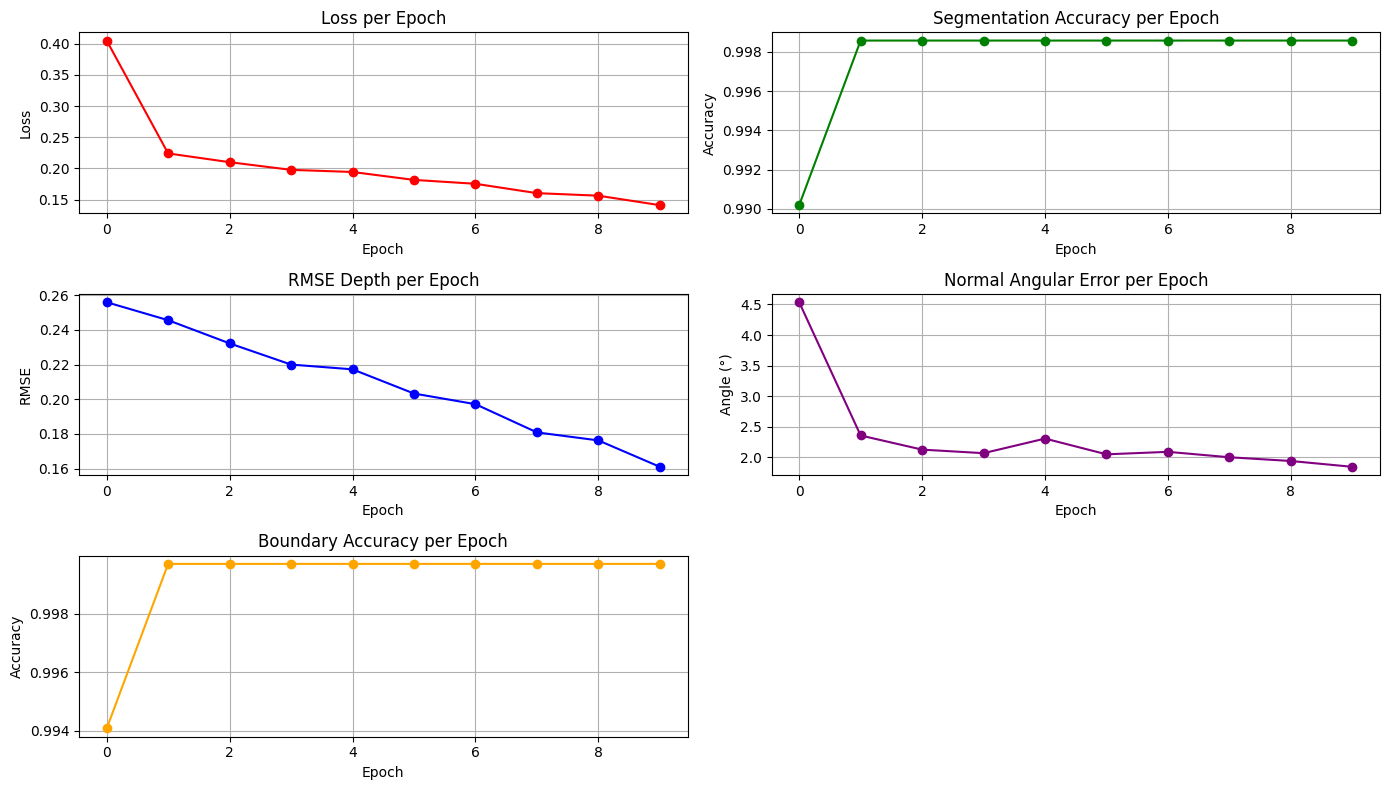

In [ ]:
#visual grapgh of output results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot 1: Loss
plt.subplot(3, 2, 1)
plt.plot(history['loss'], marker='o', color='red')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot 2: Segmentation Accuracy
plt.subplot(3, 2, 2)
plt.plot(history['seg_acc'], marker='o', color='green')
plt.title("Segmentation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

# Plot 3: RMSE Depth
plt.subplot(3, 2, 3)
plt.plot(history['rmse_depth'], marker='o', color='blue')
plt.title("RMSE Depth per Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

# Plot 4: Normal Angular Error
plt.subplot(3, 2, 4)
plt.plot(history['normal_err'], marker='o', color='purple')
plt.title("Normal Angular Error per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Angle (°)")
plt.grid(True)

# Plot 5: Boundary Accuracy
plt.subplot(3, 2, 5)
plt.plot(history['boundary_acc'], marker='o', color='orange')
plt.title("Boundary Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


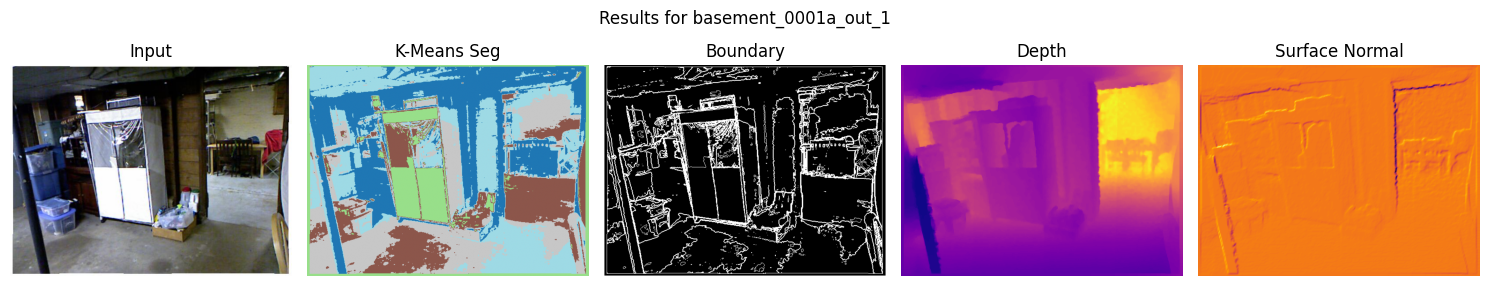

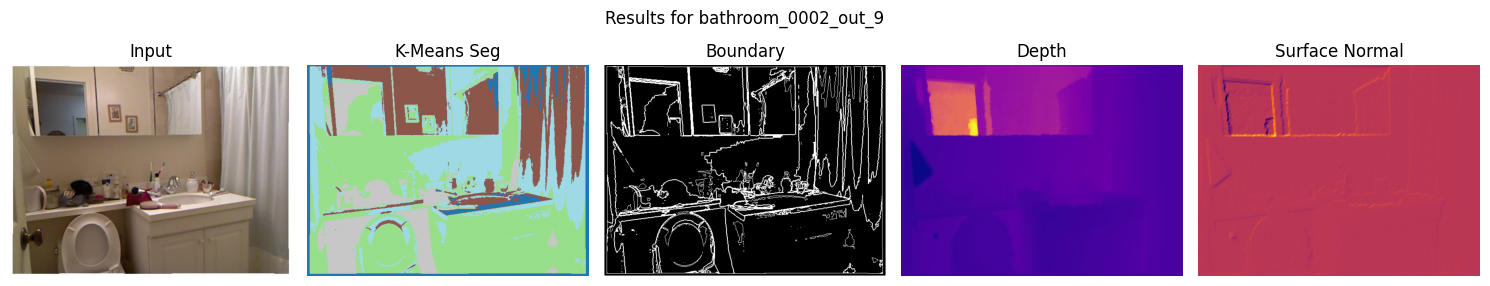

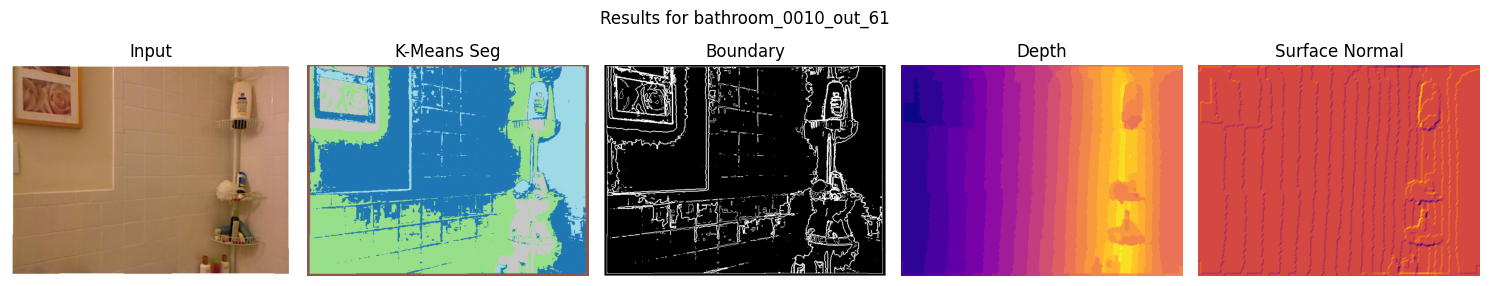

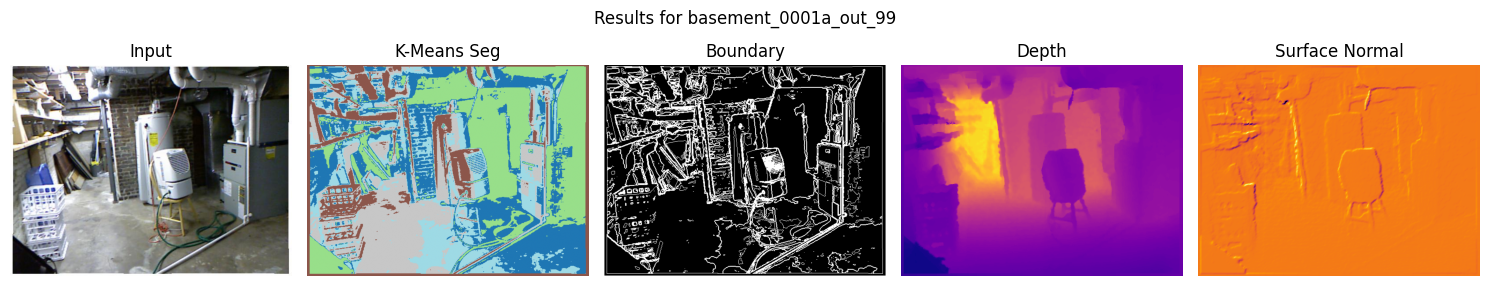

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ K-Means Segmentation + Boundary
def kmeans_segmentation_and_boundary(img_path, K=5):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Z = img_rgb.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, _ = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    segmented_labels = labels.flatten().reshape(img_rgb.shape[:2]).astype(np.uint8)

    boundary_mask = np.zeros_like(segmented_labels, dtype=np.uint8)
    for i in range(K):
        mask = (segmented_labels == i).astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(boundary_mask, contours, -1, 255, 1)

    return img_rgb, segmented_labels, boundary_mask

# ✅ Normalize for plotting
def normalize_map(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

# ✅ Visualize Surface Normal with Shading
def visualize_normal_with_shading(normals, light_direction=np.array([0.3, 0.3, 1])):
    normals = normals.astype(np.float32)
    normals /= (np.linalg.norm(normals, axis=2, keepdims=True) + 1e-8)
    light_dir = light_direction / np.linalg.norm(light_direction)
    dot = np.clip(np.sum(normals * light_dir.reshape(1, 1, 3), axis=2), 0, 1)
    return dot

# ✅ Process & Display for Given Images
image_list = ['basement_0001a_out_1', 'bathroom_0002_out_9', 'bathroom_0010_out_61','basement_0001a_out_99']
raw_folder = '/content/drive/MyDrive/DeMT/data/nyu2_train/'
npz_folder = '/content/drive/MyDrive/DeMT/data/nyud_preprocessed/'

for img_name in image_list:
    img_path = raw_folder + img_name + '.jpg'
    npz_path = npz_folder + img_name + '.npz'

    img_rgb, segmented, boundary = kmeans_segmentation_and_boundary(img_path)
    data = np.load(npz_path)

    depth = data['depth']
    normal = data['normal']
    shaded_normal = visualize_normal_with_shading(normal)

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(f"Results for {img_name}", fontsize=12)

    axs[0].imshow(img_rgb)
    axs[0].set_title("Input")
    axs[0].axis('off')

    axs[1].imshow(segmented, cmap='tab20')
    axs[1].set_title("K-Means Seg")
    axs[1].axis('off')

    axs[2].imshow(boundary, cmap='gray')
    axs[2].set_title("Boundary")
    axs[2].axis('off')

    axs[3].imshow(normalize_map(depth), cmap='plasma')
    axs[3].set_title("Depth")
    axs[3].axis('off')

    axs[4].imshow(shaded_normal, cmap='inferno')
    axs[4].set_title("Surface Normal")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()
